# HSE 2021: Mathematical Methods for Data Analysis



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hands. 

### Task 1 <a id="task1"></a> 

Implement the function `H()` which calculates impurity criterion. We will be training regression tree, therefore, impurity criterion will be variance.

* You cannot use loops
* If `y` is empty, the function should return 0

In [ ]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if y.size == 0:
      return 0
    m = np.mean(y)
    imp_crit = np.sum((y-m)**2) / y.size
    return imp_crit

In [ ]:
# Test the function
assert np.allclose(H(np.array([4,2,2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [ ]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """   
    X_l = X[:,j] <= t
    X_r = X[:,j] > t
    y_l = np.where(X_l,y,'NaN')
    y_r = np.where(X_r,y,'NaN')
    y_l_final = y_l[y_l != 'NaN'].astype(np.float)
    y_r_final = y_r[y_r != 'NaN'].astype(np.float)
    if len(y_l_final) == 0 or len(y_r_final) == 0:
      return None
    
    Q = (np.count_nonzero(X_l)/y.size) * H(y_l_final) + (np.count_nonzero(X_r)/y.size) * H(y_r_final)
    return Q

### Task 3 <a id="task3"></a>  

Now, let's implement `MyDecisionTreeRegressor` class. 

In [ ]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'.format(self.column, self.threshold, self.prediction)
        return node_desc

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """ 
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
            
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        best_cost = -999
        impurity = H(y)

        for i in range(X.shape[1]):
          X_current = X[:,i]
          for thres in X_current:
            Q_cur = Q(X, y, i, thres)
            if Q_cur is None:
              continue
            imp_current = impurity - Q_cur
            if imp_current > best_cost:
              best_cost = imp_current
              best_split_column = i
              best_threshold = thres
        if best_cost == -999:
          return None, None, None, None, None, None
        X_split = X[:, best_split_column]
        X_left = X[X_split<=best_threshold,:]
        X_right = X[X_split>best_threshold,:]
        y_left = y[X_split<=best_threshold]
        y_right = y[X_split>best_threshold]
        
        return best_split_column, best_threshold, X_left, y_left, X_right, y_right
    
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth` and `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        return False
        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        
        if self.is_terminal(node, y):
            node.is_terminal = True
            return
        if len(np.unique(y)) == 1:
            node.is_terminal = True
            return

        best_split_column, best_threshold, X_left, y_left, X_right, y_right = self.best_split(X,y)

        if best_split_column is None:
          node.is_terminal = True
          return
        
        node.column = best_split_column
        node.threshold = best_threshold
        node.left = Node()
        node.left.depth = node.depth + 1
        node.left.prediction = np.mean(y_left)

        node.right = Node()
        node.right.depth = node.depth + 1
        node.right.prediction = np.mean(y_right)
        
        print('Depth - ', node.right.depth)

        self.grow_tree(node.left, X_left, y_left)
        self.grow_tree(node.right, X_right, y_right)
        

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        
        # Initialize the tree (root node)
        self.tree_ = Node()                             
        self.tree_.depth = 1                            
        self.tree_.prediction = np.mean(y)
        
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self        
    
    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
      
        if node.is_terminal == True:
          return node.prediction
        if x[node.column] > node.threshold:
          y_pred = self.get_prediction(node.right,x)
        else:
          y_pred = self.get_prediction(node.left,x)
        
        return y_pred
    
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [ ]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

Depth -  2
Depth -  3
Depth -  2
Depth -  3
Depth -  2
Depth -  3
Depth -  2
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  2
Depth -  2
Depth -  3
Depth -  2
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  2
Depth -  3
Depth -  2
Depth -  2
Depth -  2
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3


### Task 4 <a id="task4"></a>

Load boston dataset and split it on the train ($70\%$) and test ($30\%$). Fit Decision Tree of depth 1 and make the following plot:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model 

In [ ]:
from sklearn.datasets import load_boston

data = load_boston()

X = data.data
y = data.target
columns = data.feature_names

In [ ]:
from sklearn.model_selection import train_test_split

datafr = pd.DataFrame(X, columns = columns)
datafr['target'] = y
X_train, X_test, y_train, y_test = train_test_split(datafr.drop('target', axis=1), datafr.target, 
                                                    test_size=0.3, random_state=123)
datafr.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
DTmodel = MyDecisionTreeRegressor(max_depth=2)
DTmodel.fit(X_train, y_train)
y_pred = DTmodel.predict(X_test)

Depth -  2


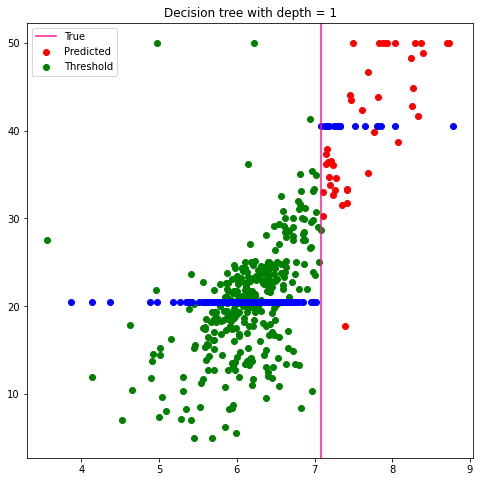

In [ ]:
import matplotlib.pyplot as plt

X_plot_train = X_train.iloc[:,DTmodel.tree_.column]
X_plot_test = X_test.iloc[:,DTmodel.tree_.column]

figure, sc = plt.subplots()

sc.scatter(X_plot_train[X_plot_train > DTmodel.tree_.threshold], y_train[X_plot_train > DTmodel.tree_.threshold], c = 'r')
sc.scatter(X_plot_train[X_plot_train <= DTmodel.tree_.threshold], y_train[X_plot_train <= DTmodel.tree_.threshold], c = 'g')
sc.scatter(X_plot_test, y_pred, c = 'b')

plt.axvline(DTmodel.tree_.threshold, color = 'deeppink')

sc.set_title('Decision tree with depth = 1')

figure.set_figwidth(8)
figure.set_figheight(8)

plt.legend(['True','Predicted','Threshold'])
plt.show()


### Task 5 <a id="task5"></a> 

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters (`max_depth` and `min_samples_split`) on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `RMSE` on test dataset and hyperparameters of the best estimator. 

In [ ]:
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

parameters = {'max_depth':[1, 3, 5, 7, 10], 'min_samples_split' : [2,5,10,20]}

DTmodelGS = GridSearchCV(DTmodel, param_grid=parameters, cv=5) 

DTmodelGS.fit(X_train, y_train)
y_pred = DTmodelGS.predict(X_test)
rmse_test = rmse(y_test, y_pred)

print('Best parameters: ', DTmodelGS.best_params_)
print('RMSE: ', rmse_test)

Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  4
Depth -  5
Depth -  4
Depth -  5
Depth -  5
Depth -  3
Depth -  4
Depth -  5
Depth -  5
Depth -  4
Depth -  5
Depth -  2
Depth -  3
Depth -  4
Depth -  5
Depth -  5
Depth -  4
Depth -  5
Depth -  5
Depth -  3
Depth -  4
Depth -  5
Depth -  4
Depth -  5
Depth -  5
Depth -  2
Depth -  3
Depth -  4
Depth -  5
Depth -  4

### Task 6 <a id="task6"></a>  

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized. 

In [ ]:
from sklearn.ensemble import BaggingClassifier

def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias and variance of the `estimator`. Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """
    X_boot = []
    Z = []
    indices_Z_max = np.arange(len(y))
    mat_predict = np.empty(shape=(len(y),n_iter))
    mat_predict.fill(np.nan)
    for i in range(n_iter):
      print('I = ',i)
      indices_X = np.random.randint(0,len(y),len(y))
      while len(np.unique(indices_X)) == len(y):
        indices_X = np.random.randint(0,len(y),len(y))
      X_extra = x.values[indices_X[:]]
      y_extra_Xtrain = y.values[indices_X[:]]
      X_boot.append(X_extra)
      indices_Z = np.setdiff1d(indices_Z_max,indices_X)
      Z_extra = x.values[indices_Z[:]]
      y_extra_Ztest = y.values[indices_Z[:]]
      Z.append(Z_extra)
      estimator.fit(X_extra,y_extra_Xtrain)
      mat_predict[indices_Z,i] = estimator.predict(Z_extra)
    
    bias = (y.values - np.nanmean(mat_predict,axis=1))**2
    bias_av = np.nanmean(bias)

    var = np.nanstd(mat_predict,axis=1)**2
    var_av = np.nanmean(var)
    return bias_av,var_av



In [ ]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train, y_train, 10)

I =  0
Depth -  2
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  5
Depth -  6
Depth -  7
Depth -  8
Depth -  7
Depth -  8
Depth -  8
Depth -  4
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  7
Depth -  5
Depth -  6
Depth -  7
Depth -  8
Depth -  4
Depth -  5
Depth -  5
Depth -  6
Depth -  7
Depth -  8
Depth -  8
Depth -  6
Depth -  7
Depth -  8
I =  1
Depth -  2
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  4
Depth -  5
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  8
Depth -  7
Depth -  8
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  8
Depth -  5
Depth -  6
Depth -  7
Depth -  7
Depth -  8
Depth -  6
I =  2
Depth -  2
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  8
Depth -  7
Depth -  8
Depth -  5
Depth -  6
Depth -  7
Depth -  8
Depth -  7
Depth -  8
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  6
Depth -  7
Depth -  8
Depth -  5
Depth -  6
Depth -  7
Depth -  8
Depth -  3
Depth -  4
Depth -  5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


(19.15829452000969, 7.689804299954392)

### Task 7 <a id="task7"></a>  

Compute bias and variance for the trees of different depths. Plot how bias and variance change as depth increases. 

Comment on what you observe, how does your result correspond to what we have discussed in class?

In [ ]:
depths = [1,3,7,10]
bias_ar = []
variance_ar = []
for el in depths:
  print('Max_depth = ', el)
  estimator = MyDecisionTreeRegressor(max_depth=el, min_samples_split=15)
  bias, variance = get_bias_variance(estimator, X_train, y_train, 10)
  bias_ar.append(bias)
  variance_ar.append(variance)

Max_depth =  1
I =  0
I =  1
I =  2
I =  3
I =  4
I =  5
I =  6
I =  7
I =  8
I =  9
Max_depth =  3
I =  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Depth -  2
Depth -  3
Depth -  3
I =  1
Depth -  2
Depth -  3
Depth -  3
I =  2
Depth -  2
Depth -  3
Depth -  3
I =  3
Depth -  2
Depth -  3
Depth -  3
I =  4
Depth -  2
Depth -  3
Depth -  3
I =  5
Depth -  2
Depth -  3
Depth -  3
I =  6
Depth -  2
Depth -  3
Depth -  3
I =  7
Depth -  2
Depth -  3
Depth -  3
I =  8
Depth -  2
Depth -  3
Depth -  3
I =  9
Depth -  2
Depth -  3
Depth -  3
Max_depth =  7
I =  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Depth -  2
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  7
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  7
Depth -  6
Depth -  7
Depth -  5
Depth -  6
Depth -  7
Depth -  3
Depth -  4
Depth -  5
Depth -  4
Depth -  5
I =  1
Depth -  2
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  5
Depth -  6
Depth -  6
Depth -  7
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  6
Depth -  7
Depth -  5
Depth -  6
Depth -  7
Depth -  3
Depth -  4
Depth -  5
I =  2
Depth -  2
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  7
Depth -  6
Depth -  7
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  5
Depth -  6
Depth -  6
Depth -  7
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  6
Depth -  4
Depth -  5
Depth -  6
I =  3
Depth -  2
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  6
Depth -  7
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  6
Depth -  7
Depth -  7
Depth -  5
Depth -  6
Depth -  7
Depth -  3
Depth -  4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Depth -  2
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  8
Depth -  9
Depth -  10
Depth -  7
Depth -  5
Depth -  6
Depth -  7
Depth -  8
Depth -  9
Depth -  10
Depth -  8
Depth -  9
Depth -  10
Depth -  4
Depth -  5
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  8
Depth -  9
Depth -  9
Depth -  10
Depth -  5
Depth -  6
Depth -  7
Depth -  8
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  8
Depth -  7
Depth -  8
Depth -  5
Depth -  6
I =  1
Depth -  2
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  8
Depth -  9
Depth -  10
Depth -  9
Depth -  8
Depth -  9
Depth -  10
Depth -  9
Depth -  10
Depth -  10
Depth -  6
Depth -  7
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  5
Depth -  6
Depth -  7
Depth -  8
Depth -  9
Depth -  6
Depth -  7
Depth -  7
Depth -  8
Depth -  9
Depth -  10
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  6
Depth -  7
Depth -  8
Depth -  4
Depth -  5
Depth -  6
I =  2
Depth -  2
Depth -  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


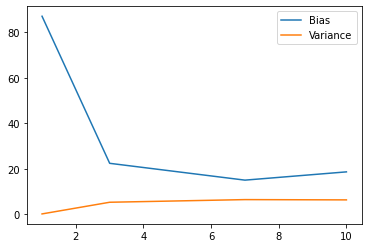

In [ ]:
plt.plot(depths,bias_ar)
plt.plot(depths,variance_ar)
plt.legend(["Bias", "Variance"])

The main problem of deep decision trees - they are prone to overfitting. That's why when we set max_depth we limit risk of overfitting but on account of error due to bias. And when we set max_depth we can get the model with less variance. 

That is what we see on the plot: as deeper tree - as higher variance, but lower bias. 

### Task 8 <a id="task8"></a>  

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [ ]:
from sklearn.ensemble import BaggingRegressor

In [ ]:
# PAY ATTENTION: this can run for 45 minutes, it's okay
depths = [1,3,7,10]
bias_ar_bag = []
variance_ar_bag = []
for el in depths:
  print('Max_depth = ', el)
  estimator_bag = MyDecisionTreeRegressor(max_depth=el, min_samples_split=15)
  model = BaggingRegressor(base_estimator=estimator_bag,n_estimators=10)
  bias, variance = get_bias_variance(model, X_train, y_train, 10)
  bias_ar_bag.append(bias)
  variance_ar_bag.append(variance)

Max_depth =  1
I =  0
I =  1
I =  2
I =  3
I =  4
I =  5
I =  6
I =  7
I =  8
I =  9
Max_depth =  3
I =  0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
I =  1
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
I =  2
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -  3
Depth -  2
Depth -  3
Depth -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Depth -  2
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  6
Depth -  7
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  7
Depth -  5
Depth -  6
Depth -  7
Depth -  7
Depth -  3
Depth -  4
Depth -  5
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  2
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  5
Depth -  4
Depth -  5
Depth -  6
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  6
Depth -  7
Depth -  5
Depth -  6
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  5
Depth -  6
Depth -  7
Depth -  6
Depth -  7
Depth -  2
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  6
Depth -  7
Depth -  5
Depth -  6
Depth -  7
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  7
Depth -  5
Depth -  6
Depth -  7
Depth -  6
Depth -  7
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  5
Depth -  6
Depth -  7
Depth -  4
Depth -  2
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  6
Depth -  7
Depth -  4
Depth -  5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


Depth -  2
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  8
Depth -  6
Depth -  7
Depth -  8
Depth -  9
Depth -  7
Depth -  8
Depth -  9
Depth -  10
Depth -  9
Depth -  10
Depth -  4
Depth -  5
Depth -  6
Depth -  6
Depth -  7
Depth -  8
Depth -  9
Depth -  10
Depth -  7
Depth -  8
Depth -  9
Depth -  10
Depth -  10
Depth -  5
Depth -  6
Depth -  7
Depth -  6
Depth -  7
Depth -  8
Depth -  9
Depth -  8
Depth -  3
Depth -  4
Depth -  5
Depth -  4
Depth -  5
Depth -  2
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  8
Depth -  9
Depth -  7
Depth -  8
Depth -  9
Depth -  10
Depth -  8
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  7
Depth -  8
Depth -  9
Depth -  10
Depth -  9
Depth -  6
Depth -  7
Depth -  8
Depth -  7
Depth -  8
Depth -  5
Depth -  6
Depth -  7
Depth -  8
Depth -  9
Depth -  10
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  6
Depth -  7
Depth -  4
Depth -  2
Depth -  3
Depth -  4
Depth -  5
Depth -  6
Depth -  7
Depth -  8
De

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


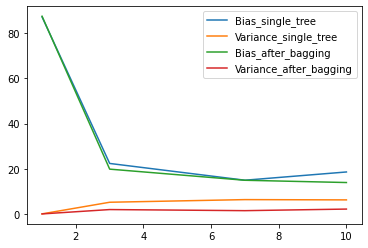

In [ ]:
plt.plot(depths,bias_ar)
plt.plot(depths,variance_ar)
plt.plot(depths,bias_ar_bag)
plt.plot(depths,variance_ar_bag)
plt.legend(["Bias_single_tree", "Variance_single_tree","Bias_after_bagging", "Variance_after_bagging"])

In theory, bagging effects our model in that way: it reduces variance without effecting bias. 
As we see in comparison to single decision tree - variance decreases while level of bias is the same due to depth of 3. The depth of tree effects level of bias. 
As deeper tree as lower is the level of variance and bias after BaggingRegressor (if we compare to single tree level of variance and bias).  
That's why we can say, that your result align with theory. 

# Part 2. More Ensembles

In this part we will be working with [Thyroid Disease Data Set](https://archive.ics.uci.edu/ml/datasets/thyroid+disease) to solve a classification task. 

In [ ]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('thyroid_disease.csv')

le = LabelEncoder()
y = le.fit_transform(df['Class'])
X = df.drop('Class', axis=1)
X.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source
0,41.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.30,t,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC
1,23.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.10,t,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other
2,46.0,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other
3,70.0,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other
4,70.0,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI


### Task 1 <a id="task2_1"></a> 

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding
    - Numeric: Fill missing values





In [ ]:
names_object = []
names_float = []
for i in range(X.shape[1]):
  if X.dtypes[i] == 'object':
    names_object.append(X.columns.values[i])
  else:
    names_float.append(X.columns.values[i])
  print('NAN = ', X.iloc[:,i].isna().sum())
  print('TOTAL = ', X.shape[0])
  print(X.iloc[:,i].value_counts())


NAN =  1
TOTAL =  3772
59.0     95
60.0     91
70.0     90
73.0     81
55.0     81
         ..
455.0     1
6.0       1
4.0       1
10.0      1
5.0       1
Name: age, Length: 93, dtype: int64
NAN =  150
TOTAL =  3772
F    2480
M    1142
Name: sex, dtype: int64
NAN =  0
TOTAL =  3772
f    3308
t     464
Name: on_thyroxine, dtype: int64
NAN =  0
TOTAL =  3772
f    3722
t      50
Name: query_on_thyroxine, dtype: int64
NAN =  0
TOTAL =  3772
f    3729
t      43
Name: on_antithyroid_medication, dtype: int64
NAN =  0
TOTAL =  3772
f    3625
t     147
Name: sick, dtype: int64
NAN =  0
TOTAL =  3772
f    3719
t      53
Name: pregnant, dtype: int64
NAN =  0
TOTAL =  3772
f    3719
t      53
Name: thyroid_surgery, dtype: int64
NAN =  0
TOTAL =  3772
f    3713
t      59
Name: I131_treatment, dtype: int64
NAN =  0
TOTAL =  3772
f    3538
t     234
Name: query_hypothyroid, dtype: int64
NAN =  0
TOTAL =  3772
f    3535
t     237
Name: query_hyperthyroid, dtype: int64
NAN =  0
TOTAL =  3772
f    3754


In [ ]:
columns = names_object + names_float

I decided to drop such columns as: TBG_measured(because it has only one value, which is 'f'), T3 (769 NAN - it is too much of nan values) and TBG (because it has all NAN values). 

Though i decided to left such columns as FTI (385 NAN), T4U (387 NAN), TT4 (231 NAN), TSH (369 NAN). They have enough nan values, but removing of them can effect the accurancy of our model. 

In [ ]:
X = X.drop(['TBG_measured', 'T3', 'TBG'], axis=1)


In [ ]:
columns.remove('TBG_measured')
columns.remove('T3')
columns.remove('TBG')

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
print(X_train)

       age sex on_thyroxine  ... FTI_measured    FTI referral_source
621   84.0   F            t  ...            t  216.0           other
3163  32.0   F            f  ...            f    NaN           other
759   64.0   F            f  ...            t  125.0           other
1179  43.0   F            t  ...            t  182.0           other
196   71.0   F            f  ...            t  119.0           other
...    ...  ..          ...  ...          ...    ...             ...
1122  74.0   F            t  ...            t   87.0           other
1346  42.0   F            f  ...            t  134.0           other
3454  79.0   F            f  ...            t  107.0             SVI
3437  42.0   M            f  ...            t   70.0           other
3582  40.0   F            f  ...            t   95.0            STMW

[2640 rows x 26 columns]


In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector


double_transform_binary = make_pipeline(SimpleImputer(strategy = 'most_frequent'),OrdinalEncoder(dtype='int'))
double_transform = make_pipeline(SimpleImputer(strategy = 'most_frequent'),OneHotEncoder(dtype='int'))
column_transformer = ColumnTransformer([    
    ('For_Object_binary', double_transform_binary, make_column_selector(dtype_include = object)),                     
    ('For_Float', SimpleImputer(strategy = 'most_frequent'), make_column_selector(dtype_include = float))], remainder='passthrough')

X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

In [ ]:
X_train_df = pd.DataFrame(X_train,columns=columns)
X_train_df

,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,T3_measured,TT4_measured,T4U_measured,FTI_measured,referral_source,age,TSH,TT4,T4U,FTI
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,4.0,84.0,0.04,213.0,0.99,216.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,32.0,0.20,103.0,0.99,100.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,4.0,64.0,0.10,113.0,0.91,125.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,4.0,43.0,0.20,197.0,1.08,182.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,4.0,71.0,0.02,127.0,1.06,119.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,74.0,6.30,80.0,0.92,87.0
2636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,42.0,1.60,139.0,1.04,134.0
2637,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.0,79.0,1.30,102.0,0.95,107.0
2638,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,42.0,5.10,53.0,0.76,70.0


In [ ]:
X_test_df = pd.DataFrame(X_test,columns=columns)
X_test_df

,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,T3_measured,TT4_measured,T4U_measured,FTI_measured,referral_source,age,TSH,TT4,T4U,FTI
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,57.0,0.200,103.0,0.99,100.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,41.0,0.005,100.0,1.01,99.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.0,66.0,1.700,89.0,0.87,103.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,67.0,1.900,133.0,1.18,113.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,62.0,1.100,130.0,1.24,105.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.0,56.0,0.200,138.0,1.15,119.0
1128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,80.0,1.100,118.0,1.12,105.0
1129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,38.0,1.500,122.0,1.46,83.0
1130,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,3.0,77.0,0.900,100.0,0.80,124.0


### Task 2 <a id="task2_2"></a> 

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. 
* Which model has the best performance? Which models overfit or underfit?

I decided to use such classification metric as F1-measure. 

First of all, we have unbalanced classes. In that case using accurancy as metric will be pointless. 
Regarding to our dataset, we need to classify if human is ill or not -> we need to pay special attention to False Positive и False Negative classification errors. In that case will be usefull to take care about precision and recall. 
And F1-measure is medium harmonic of precision and recall. 

The F-measure reaches its maximum at completeness and accuracy. 

In [ ]:
unique, counts = np.unique(y, return_counts=True)
print(counts)

[3541  231]


In [ ]:
X_transformed = column_transformer.fit_transform(X)

In [ ]:
# -> classes are not balanced, that's why we should use cross validation with StratifiedKFold
from sklearn.model_selection import StratifiedKFold
def predictWithCV(model, X, y):
  stratifiedCV = StratifiedKFold(n_splits=10)
  splits = np.arange(10)
  y_pred = y.copy()
  MSE_test = []
  MSE_train = []
  for i,j in stratifiedCV.split(X, y):
    y_train = y[i]
    y_test = y[j]
    X_train, X_test = X[i], X[j]
    model.fit(X_train, y_train)
    y_pred[j] = model.predict(X_test)
    MSE_train.append(mean_squared_error(y_train, model.predict(X_train)))
    MSE_test.append(mean_squared_error(y_test, model.predict(X_test)))
  plt.plot(splits,MSE_train)
  plt.plot(splits,MSE_test)
  plt.legend(["MSE_train", "MSE_test"])
  return y_pred

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3541
           1       0.00      0.00      0.00       231

    accuracy                           0.94      3772
   macro avg       0.47      0.50      0.48      3772
weighted avg       0.88      0.94      0.91      3772

Score:  0.9387592788971368


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


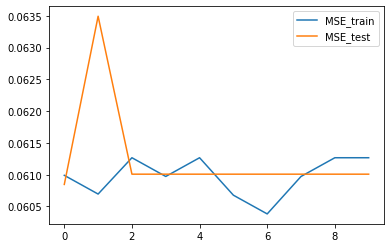

In [ ]:
# Gradient Boosting
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error


clf_GB = GradientBoostingClassifier(n_estimators=10, random_state=123)

pred_GB = predictWithCV(clf_GB, X_transformed, y)
report_GB = classification_report(y, pred_GB)
print(report_GB)
print('Score: ',accuracy_score(y, pred_GB))

In [ ]:
clf = GradientBoostingClassifier(n_estimators=10, random_state=123).fit(X_test,y_test)
print('GradientBoostingClassifier MSE train without cross validation: ', mean_squared_error(y_train, clf.predict(X_train)))
print('GradientBoostingClassifier MSE test without cross validation: ', mean_squared_error(y_test, clf.predict(X_test)))

GradientBoostingClassifier MSE train without cross validation:  0.06098484848484848
GradientBoostingClassifier MSE test without cross validation:  0.05830388692579505


              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3541
           1       0.65      0.17      0.27       231

    accuracy                           0.94      3772
   macro avg       0.80      0.58      0.62      3772
weighted avg       0.93      0.94      0.93      3772

Score:  0.9435312831389183


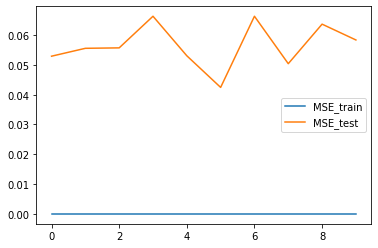

In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

clf_RF = RandomForestClassifier(n_estimators=100, random_state=123)

pred_RF = predictWithCV(clf_RF, X_transformed, y)
report_RF = classification_report(y, pred_RF)
print(report_RF)
print('Score: ',accuracy_score(y, pred_RF))

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=123).fit(X_test,y_test)
print('RandomForestClassifier MSE train without cross validation: ', mean_squared_error(y_train, clf.predict(X_train)))
print('RandomForestClassifier MSE test without cross validation: ', mean_squared_error(y_test, clf.predict(X_test)))

RandomForestClassifier MSE train without cross validation:  0.06136363636363636
RandomForestClassifier MSE test without cross validation:  0.0


              precision    recall  f1-score   support

           0       0.96      0.95      0.96      3541
           1       0.35      0.39      0.37       231

    accuracy                           0.92      3772
   macro avg       0.66      0.67      0.66      3772
weighted avg       0.92      0.92      0.92      3772

Score:  0.9186108165429481


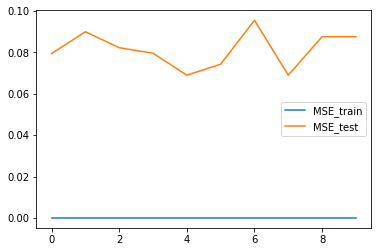

In [ ]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

clf_DT = DecisionTreeClassifier(random_state=123)

pred_DT = predictWithCV(clf_DT, X_transformed, y)
report_DT = classification_report(y, pred_DT)
print(report_DT)
print('Score: ',accuracy_score(y, pred_DT))

In [ ]:
clf = DecisionTreeClassifier(random_state=123).fit(X_test,y_test)
print('DecisionTreeClassifier MSE train without cross validation: ', mean_squared_error(y_train, clf.predict(X_train)))
print('DecisionTreeClassifier MSE test without cross validation: ', mean_squared_error(y_test, clf.predict(X_test)))

DecisionTreeClassifier MSE train without cross validation:  0.09583333333333334
DecisionTreeClassifier MSE test without cross validation:  0.0


              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3541
           1       0.00      0.00      0.00       231

    accuracy                           0.94      3772
   macro avg       0.47      0.50      0.48      3772
weighted avg       0.88      0.94      0.91      3772

Score:  0.9387592788971368


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


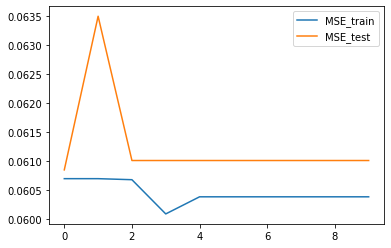

In [ ]:
# SVM
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

clf_SVM = make_pipeline(StandardScaler(), SVC(gamma='auto'))

pred_SVM = predictWithCV(clf_SVM, X_transformed, y)
report_SVM = classification_report(y, pred_SVM)
print(report_SVM)
print('Score: ',accuracy_score(y, pred_SVM))

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto')).fit(X_test,y_test)
print('SVC MSE train without cross validation: ', mean_squared_error(y_train, clf.predict(X_train)))
print('SVC MSE test without cross validation: ', mean_squared_error(y_test, clf.predict(X_test)))

SVC MSE train without cross validation:  0.06098484848484848
SVC MSE test without cross validation:  0.060954063604240286


              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3541
           1       0.48      0.05      0.09       231

    accuracy                           0.94      3772
   macro avg       0.71      0.52      0.53      3772
weighted avg       0.91      0.94      0.91      3772

Score:  0.9384941675503712


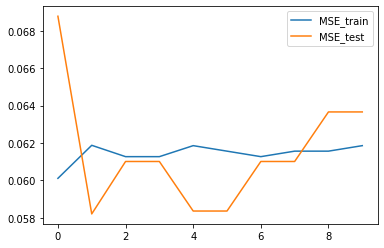

In [ ]:
# Logitics Regression
from sklearn.linear_model import LogisticRegression

clf_LR = LogisticRegression(random_state=123, max_iter=1000)

pred_LR = predictWithCV(clf_LR, X_transformed, y)
report_LR = classification_report(y, pred_LR)
print(report_LR)
print('Score: ',accuracy_score(y, pred_LR))

In [ ]:
clf = LogisticRegression(random_state=123, max_iter=1000).fit(X_test,y_test)
print('LogisticRegression MSE train without cross validation: ', mean_squared_error(y_train, clf.predict(X_train)))
print('LogisticRegression MSE test without cross validation: ', mean_squared_error(y_test, clf.predict(X_test)))

LogisticRegression MSE train without cross validation:  0.06628787878787878
LogisticRegression MSE test without cross validation:  0.05830388692579505


```your comments here```

Underfitted model has low variance and high bias. 
Model that is underfitted will have high training and high testing error while an overfitted model will have extremely low training error but a high testing error.
But as we know, cross-validation helps us with the problem of overfitting and underfitting. 

On the first plots we can see the performance of our models (MSE) due every split to train/test samples. On the second plots we can see how our model perform itself (MSE) without cross validation. 

Let's summarize all information we got from the plots. 
First of all, regarding to accurancy performance the best model is RandomForest (acc = 0.94). It also has one of the best performance in F1-measure. 

But as we see on the plots, DecisionTreeClassifier and RandomForest have very low level of train error and high level of test error. That means, those models can be overfitted. 


### Task 3 <a id="task2_3"></a> 

More Gradient Boosting. Choose one of the tree popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 



              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3541
           1       0.59      0.16      0.25       231

    accuracy                           0.94      3772
   macro avg       0.77      0.58      0.61      3772
weighted avg       0.93      0.94      0.93      3772

Score:  0.9416755037115588


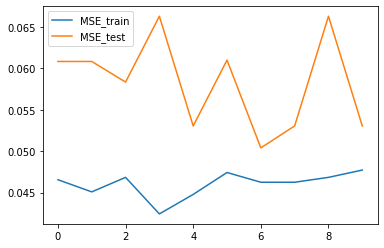

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier()
pred = predictWithCV(model, X_transformed, y)
report = classification_report(y, pred)
print(report)
print('Score: ',accuracy_score(y, pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3541
           1       0.63      0.32      0.42       231

    accuracy                           0.95      3772
   macro avg       0.79      0.65      0.70      3772
weighted avg       0.94      0.95      0.94      3772

Score:  0.9467126193001061


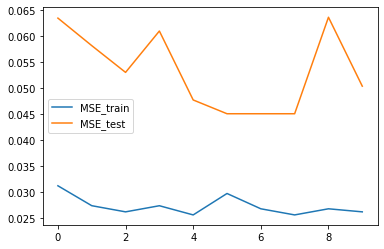

In [ ]:
model = XGBClassifier(max_depth=10,learning_rate=0.02, n_estimators=100)
pred = predictWithCV(model, X_transformed, y)
report = classification_report(y, pred)
print(report)
print('Score: ',accuracy_score(y, pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3541
           1       0.00      0.00      0.00       231

    accuracy                           0.94      3772
   macro avg       0.47      0.50      0.48      3772
weighted avg       0.88      0.94      0.91      3772

Score:  0.9379639448568399


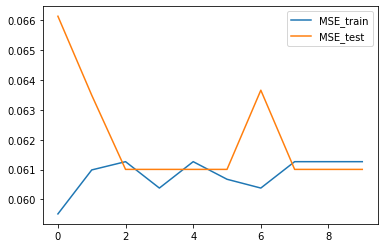

In [ ]:
model = XGBClassifier(max_depth=3,learning_rate=0.02, n_estimators=100)
pred = predictWithCV(model, X_transformed, y)
report = classification_report(y, pred)
print(report)
print('Score: ',accuracy_score(y, pred))

As we see XGBClassifier on default hyperparameters improved the accurancy. It also help us with overfitting problem (MSE_train and MSE_test is about the same level). 

When we change learning rate to 0.02 we can get the better model performance. But if we try to increase max_depth our model start performing worse in case of (MSE_test connected with MSE_train overfitting). 

### Task 4 <a id="task2_4"></a> 

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* Voting classifier
* Stacking Classifier with Logistic Regression as a final model
* Stacking Classifier with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [ ]:
from sklearn.tree import DecisionTreeClassifier

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3541
           1       0.00      0.00      0.00       231

    accuracy                           0.94      3772
   macro avg       0.47      0.50      0.48      3772
weighted avg       0.88      0.94      0.91      3772

Score:  0.9387592788971368


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


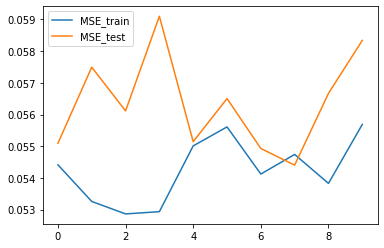

In [ ]:
# Bagging with decision trees as base estimators
estimator_bag = DecisionTreeClassifier(max_depth=3, min_samples_split=5, random_state=123)
model = BaggingRegressor(base_estimator=estimator_bag,n_estimators=100)
pred = predictWithCV(model, X_transformed, y)
report = classification_report(y, pred)
print(report)
print('Score: ',accuracy_score(y, pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3541
           1       0.50      0.03      0.05       231

    accuracy                           0.94      3772
   macro avg       0.72      0.51      0.51      3772
weighted avg       0.91      0.94      0.91      3772

Score:  0.9387592788971368


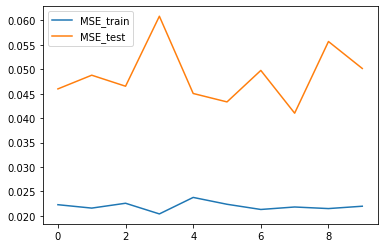

In [ ]:
# Bagging with gradient boosting (with large amount of trees, >100) as base estimators
estimator_bag = GradientBoostingClassifier(n_estimators=200, random_state=123)
model = BaggingRegressor(base_estimator=estimator_bag)
pred = predictWithCV(model, X_transformed, y)
report = classification_report(y, pred)
print(report)
print('Score: ',accuracy_score(y, pred))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3541
           1       0.54      0.03      0.06       231

    accuracy                           0.94      3772
   macro avg       0.74      0.51      0.51      3772
weighted avg       0.92      0.94      0.91      3772

Score:  0.9390243902439024


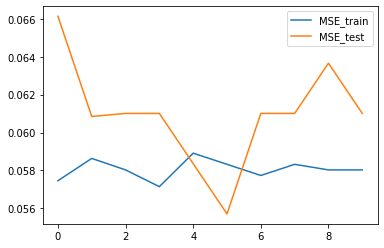

In [ ]:
# Voting classifier
from sklearn.ensemble import VotingClassifier
estimators_f = [('rf', RandomForestClassifier(n_estimators=10, random_state=123)),
              ('lr', LogisticRegression(random_state=123, max_iter=1000))]
model = VotingClassifier(estimators=estimators_f, voting='hard')
pred = predictWithCV(model, X_transformed, y)
report = classification_report(y, pred)
print(report)
print('Score: ',accuracy_score(y, pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3541
           1       0.57      0.15      0.23       231

    accuracy                           0.94      3772
   macro avg       0.76      0.57      0.60      3772
weighted avg       0.92      0.94      0.92      3772

Score:  0.940880169671262


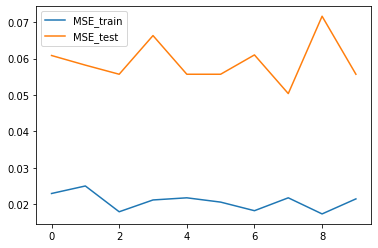

In [ ]:
# Stacking Classifier with Logistic Regression as a final model
from sklearn.ensemble import StackingClassifier
estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=123)),
              ('xgb', XGBClassifier(max_depth=3,learning_rate=0.02, n_estimators=100))]
model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=123, max_iter=1000))
pred = predictWithCV(model, X_transformed, y)
report = classification_report(y, pred)
print(report)
print('Score: ',accuracy_score(y, pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3541
           1       0.75      0.01      0.03       231

    accuracy                           0.94      3772
   macro avg       0.84      0.51      0.50      3772
weighted avg       0.93      0.94      0.91      3772

Score:  0.939289501590668


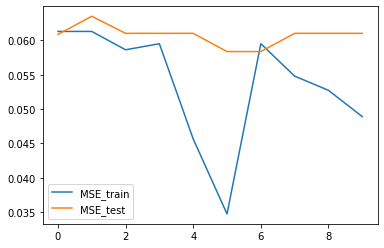

In [ ]:
# Stacking Classifier with Gradeint Boosting as a final model

model = StackingClassifier(estimators=estimators_f, final_estimator=GradientBoostingClassifier(n_estimators=10, random_state=123))
pred = predictWithCV(model, X_transformed, y)
report = classification_report(y, pred)
print(report)
print('Score: ',accuracy_score(y, pred))

To sum up: we see, that the best performance has the model of Stacking Classifier with Logistic Regression as a final model: it has one of the highest score, and F1-measure for the second class (which is very small in comparison to initial dataset), but it can be easily overfitted. 

If we take a look to plots (bagging reduce  with the gradient boosting) - we see, that it didn't effect on overfitting problem. 

The main difference of voting and staking is: voting train different models (as staking), but then it combine prediction through averaging or majority vote when stacking train final estimator on the new features. 



### Task 5 <a id="task2_5"></a> 

Report the test score for the best model, that you were able to train. 

In [ ]:
# One of the best models is XGBClassifier - high level of accurancy and the best
# permormance of F1- measure on second class (which is very small in initial dataset)
from sklearn.model_selection import cross_val_score
model = XGBClassifier(max_depth=10,learning_rate=0.02, n_estimators=100)
scores = cross_val_score(model, X_transformed, y, cv=StratifiedKFold(n_splits=10))
print('Score: ',np.mean(scores))

Score:  0.94671662947525
